# Data cleaning and sentiment <a class="anchor" id="top"></a>

## TOC:
* [Filter, clean and sentiment functions](#bullet1)
    - [Different methods data filtering and sentiment calculations](#sub-bullet1.1)
* [The correct sentiment measure](#bullet2)
    - [Sentiment measure correlation](#sub-bullet2.1)
* [Measuring stock performance using total Robinhood stock positions](#bullet3)
    - [Robinhood user growth](#sub-bullet3.1)
    - [Final solution](#sub-bullet3.2)
    - [Implementation of final solution](#sub-bullet3.3)
* [ToDo](#ToDo)
* [Vault](#Vault)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.formula.api as sm


In [6]:
path = r"E:\Users\Christiaan\Large_Files\Thesis\Twitter\merged\NFLX.csv"
df = pd.read_csv(path)

## Filter, clean and sentiment functions <a class="anchor" id="bullet1"></a>

The code below contains functions which are used on the dataframe to:
- Perform data cleaning
- Filter the data
- Calculate the sentiment

The **<u>data filtering</u>** will be done using 2 different methods.
- Method 1: Filters observations with based on the number of tickers which are mentioned in the Tweet. If this number differs from 1 ticker mentioned, the post is filtered. The second rule of this filter method is that the 1 ticker which is mentioned, is that this ticker is the ticker of the company of which the sentiment is being calculated.
- Method 2: This method is more lenient and allows for multiple tickers to be mentioned, as long as the company ticker which is being investigated is also mentioned.

The **<u>sentiment calculations</u>** will also be done using 2 different methods using the [cjhutto vaderSentiment library](https://github.com/cjhutto/vaderSentiment).
- Method 1: Uses the original cjhutto vaderSentiment library. 
- Method 2: Uses the original cjhutto vaderSentiment library, however some word-sentiment pairs are added to finetune the VADER model for financial texts. 

In [3]:
#   ---------------------------   Data cleaning   ---------------------------
def clean_text(text):
    # Remove twitter Return handles (RT @xxx:)
    text = re.sub("RT @[\w]*:", "", text)

    # Remove twitter handles (@xxx)
    text = re.sub("@[\w]*", "", text)

    # Remove URL links (httpxxx)
    url_matcher = "((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*"
    text = re.sub(url_matcher, "", text)
    
    # Remove any multiple white spaces, tabs or newlines
    text = re.sub('\s+',' ', text)
    
    #remove “”
    text = re.sub("“|”", "", text)
    
    return text

#   ---------------------------   Data filtering   ---------------------------

# Method 1 filters the posts based on only 1 rule, which is that the ticker of the company of ...
# ... which the sentiment is being calculated is present.
def filter_data_1(post, ticker):
    # Filter out posts that do not mention the company ticker.
    if bool(re.search(fr"\${ticker}", post, re.IGNORECASE)):
        return True
    else:
        return False 

# Method 2 filters the posts based on the rule that exactly 1 ticker is mentioned and ...
# ... that this ticker is the ticker of the company of which the sentiment is being calculated   
def filter_data_2(post, ticker):
    # Count the number of tickers in the post
    matches = re.findall(r"\$[a-zA-Z]+", post)
    count = len(matches)
    
    # Filter out posts with more or less than 1 ticker, and check whether this 1 ticker is the company ticker.
    if count == 1 and bool(re.search(fr"\${ticker}", post, re.IGNORECASE)):
        return True
    else:
        return False




In [4]:
# Adding word-sentiment pairs to the cjhutto vaderSentiment library.
new_words = {}

# Adding custom postive words
positive_words = {
    'buy': 2.0,
    'buying': 2.0,
    'bullish': 2.0,
    'long': 1.0,
    'call': 1.0,
    'calls': 1.0,
    'rocket': 3.0,        # Added for 'rocket' emoji 🚀
    'increasing': 2.0,     # Added for 'chart increasing' emoji 📈
    'to the moon': 2.5,
    "undervalued": 2.0
}
# Adding custom negative words
negative_words = {
    'decreasing': -2.0,   # Added for 'chart increasing' emoji 📉
    'sell': -2.0,
    'selling': -2.0,
    'bearish': -2.0,
    'put': -1,
    'puts': -1,
    'short': -1.0,
    'shorting': -1.5,
    "overvalued": -2.0,
    'expensive': -1.5
}

# Adding positive and negative words to new_worddictionary
new_words.update(positive_words)
new_words.update(negative_words)

In [5]:
#   ---------------------------   Sentiment   ---------------------------
# Creating SIA, which uses standard words.
SIA = SentimentIntensityAnalyzer()

def calc_sentiment_1(text, sent_type):
    result = SIA.polarity_scores(text)
    return result[sent_type]

# Creating SIA2 to add custom words.
SIA2 = SentimentIntensityAnalyzer()
SIA2.lexicon.update(new_words)

def calc_sentiment_2(text, sent_type):
    result = SIA2.polarity_scores(text)
    return result[sent_type]

**Merged**

Next, all functions above are put into one function which can be applied to a dataframe. The goal is to prepare all the data which is necessary for the sentiment analysis later on.

In [6]:
import time
start_time = time.time()

def clean_data(df, ticker):
    # Drop all non English Tweets and any unnnamed columns
    df = df[df['lang'] == 'en']
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    # Create some datetime items
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['date'] = df['created_at'].dt.date
    df['hour'] = df['created_at'].dt.hour
#     df['test'] = df['text'].apply(filter_data_1, ticker=ticker)
    
    #   ---------------------------   Data cleaning   ---------------------------
    # Clean text
    df['text'] = df['text'].apply(clean_text)
    print("Done cleaning after --- %s seconds ---" % (time.time() - start_time))
    
    # Drop duplicate tweets based on cleaned text (sometimes Tweets include the same text but different links for example)
    df = df.drop_duplicates(subset=['author_id', 'text'], keep=False)
    
    #   ---------------------------   Data filter   ---------------------------
    # Filter dataframe using both filter 1 and 2 (read above what they mean)
    df['filter_1'] = df['text'].apply(filter_data_1, ticker=ticker)
    df['filter_2'] = df['text'].apply(filter_data_2, ticker=ticker)
    
    print("Done filtering after --- %s seconds ---" % (time.time() - start_time))
    
    #   ---------------------------   Sentiment   ---------------------------
    # Calculate sentiment scores
    df[f'compound_sent_1'] = df['text'].astype(str).apply(calc_sentiment_1, sent_type='compound')
    df[f'compound_sent_2'] = df['text'].astype(str).apply(calc_sentiment_2, sent_type='compound')
    
    print("Done calculating sentiment after --- %s seconds ---" % (time.time() - start_time))
    
    """Converting this to pos, neg or neu sentiment
    - positive sentiment: compound score >= 0.05
    - neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
    - negative sentiment: compound score <= -0.05
    """
    
    # Check if sentiment corresponds to pos, neg or neu sentiment for compound_sent_1
    df['s1_pos'] = np.where(df['compound_sent_1'] >= 0.05, 1, 0)
    df['s1_neg'] = np.where(df['compound_sent_1'] <= -0.05, 1, 0)

    # Check if sentiment corresponds to pos, neg or neu sentiment for compound_sent_2
    df['s2_pos'] = np.where(df['compound_sent_2'] >= 0.05, 1, 0)
    df['s2_neg'] = np.where(df['compound_sent_2'] <= -0.05, 1, 0)
   
    return df

ticker = 'NFLX'

filedir = r'E:\Users\Christiaan\Large_Files\Thesis\Twitter\merged'
filename = ticker + '.csv'
path = os.path.join(filedir, filename)

df = pd.read_csv(path)

return_df = clean_data(df, ticker)

Done cleaning after --- 27.88475275039673 seconds ---
Done filtering after --- 30.92370629310608 seconds ---
Done calculating sentiment after --- 138.69587516784668 seconds ---


### Different methods data filtering and sentiment calculations <a class="anchor" id="sub-bullet1.1"></a>

As discussed above, two different methods of data filtering and sentiment calculations were performend. This resulted in 4 different combinations of data filters and sentiment calculations

| Method name | Filter | Sentiment measurement type |
| --- | --- | --- |
| f1s1 | Method 1 | Method 1 |
| f1s2 | Method 1 | Method 2 |
| f2s1 | Method 2 | Method 1 |
| f2s2 | Method 2 | Method 2 |




In [7]:
def count_posts(df):
    # Create results_df with [filter_1] [sentiment_1]
    results_df = df[df['filter_1']][['date', 's1_pos', 's1_neg']].groupby('date', as_index=False).sum().rename(columns={"s1_pos": "[f1s1]pos", "s1_neg": "[f1s1]neg"})
    results_df['[f1s1]total'] = results_df['[f1s1]pos'] + results_df['[f1s1]neg']

    # Merge [filter_1] [sentiment_2]
    to_merge_df = return_df[return_df['filter_1']][['date', 's2_pos', 's2_neg']].groupby('date', as_index=False).sum().rename(columns={"s2_pos": "[f1s2]pos", "s2_neg": "[f1s2]neg"})
    to_merge_df['[f1s2]total'] = to_merge_df['[f1s2]pos'] + to_merge_df['[f1s2]neg']
    results_df = results_df.merge(to_merge_df, how='left', left_on='date', right_on='date')

    # Merge [filter_2] [sentiment_1]
    to_merge_df = return_df[return_df['filter_2']][['date', 's1_pos', 's1_neg']].groupby('date', as_index=False).sum().rename(columns={"s1_pos": "[f2s1]pos", "s1_neg": "[f2s1]neg"})
    to_merge_df['[f2s1]total'] = to_merge_df['[f2s1]pos'] + to_merge_df['[f2s1]neg']
    results_df = results_df.merge(to_merge_df, how='left', left_on='date', right_on='date')

    # Merge [filter_2] [sentiment_2]
    to_merge_df = return_df[return_df['filter_2']][['date', 's2_pos', 's2_neg']].groupby('date', as_index=False).sum().rename(columns={"s2_pos": "[f2s2]pos", "s2_neg": "[f2s2]neg"})
    to_merge_df['[f2s2]total'] = to_merge_df['[f2s2]pos'] + to_merge_df['[f2s2]neg']
    results_df = results_df.merge(to_merge_df, how='left', left_on='date', right_on='date')
    
    return results_df
results_df = count_posts(return_df)

Resulting in the following total social media posts with a positive or negative sentiment.

---
<div>
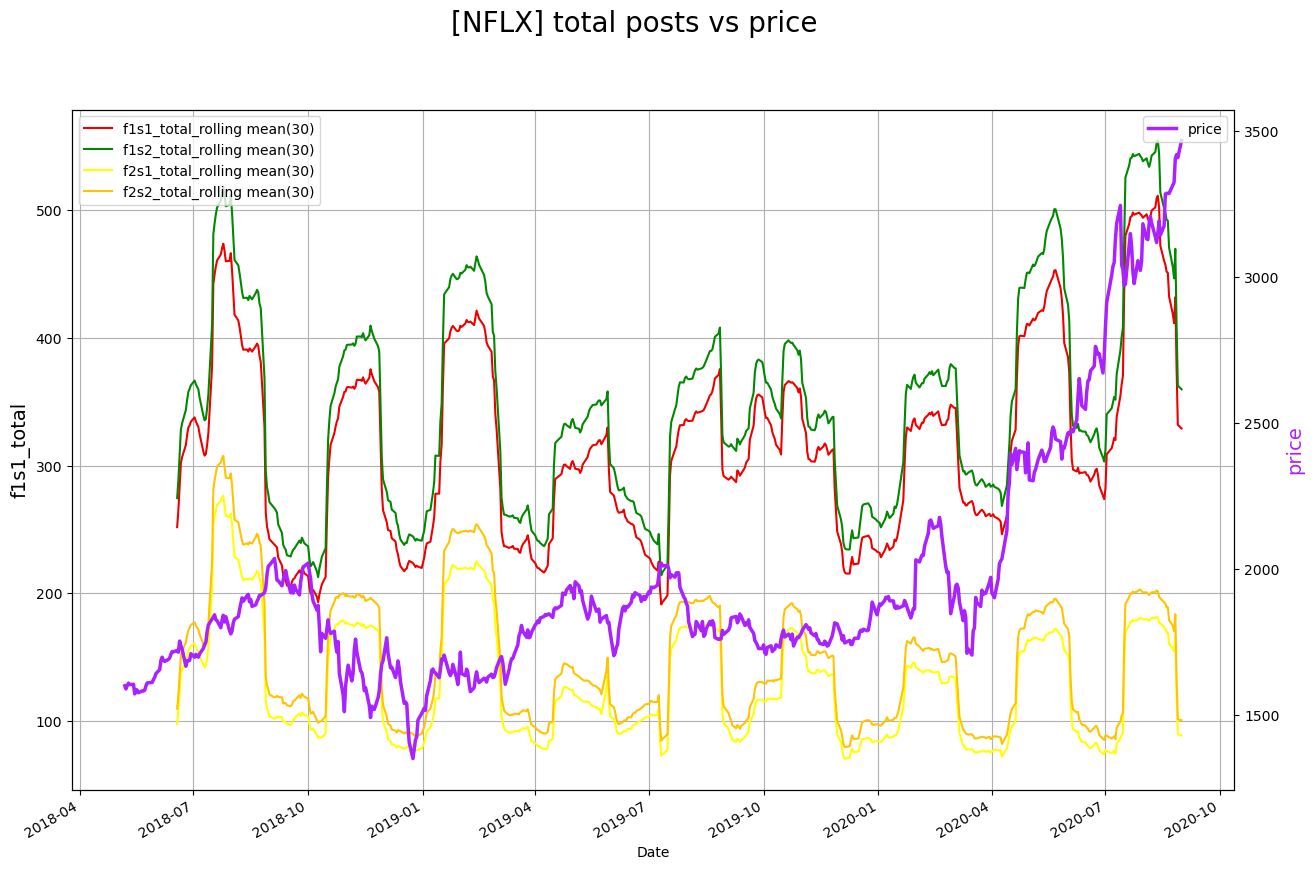
</div>

--- 

A big difference between filter 1 and filter 2 can be seen. The total amount of social media posts is significantly lower for filter 2 than for filter 1. This due to the stricter rules which filter 2 contained. Further, it can be seen that sentiment method 2 find more positive and negative post than sentiment 1. This is probably due to the extra custom rules, which cause the texts to be less likely to be categorised as neutral.

**I will only be using sentiment method 2, as this is more focussed on financial texts than the sentiment 1 method.**

## The correct sentiment measure <a class="anchor" id="bullet2"></a>

Although different data filters and sentiment measuring methods are mentioned, this does not solve the problem of how sentiment needs to be measured. Do I take the total amount of positive posts as a proxy of sentiment? Or do I use the ratio of positive and negative posts. Or do I subtract the negative posts from the positive posts and divide that figure by the total amount of posts?

It is clear that there is no clear winner here. I propose that sentiment should be measure in two parts. The first part should contain the `relative volume` of the social media posts, as large volumes are more likely to be noticable. Part 1 will thus act as a way to strengen or weaken the total sentiment score of the day, by comparing the volume of that day with the average volume of the last 7 days. The second part of the measure should contain the actual `sentiment`. Is it positive or negative? It should also capture the severity of the sentiment. 


**Part 1**
The first part is the easier one of the two parts to measure. With the sentiment tools all returning either a positive, negative or neutral label, I decide that I will solely be focussing on the positive and negative posts. This means that these are also the posts that will be taken into considerations when looking at volume. The volume will be measured by counting the total of positive and negative posts for a given day. This daily total will then be divided by the average total posts of the last 7 days.

- $\text{Relative volume}_{t0} = \frac{\text{Total positive posts}_{t0}+\text{Total negative posts}_{t0}}{Rolling mean 7(\text{Total positive posts}_{t0}+\text{Total negative posts}_{t0})}$

**Part 2**
The second part is harded, as it is unclear what the best way to measure sentiment is. To tackle this problem, I will calculate the sentiment in different ways.
- Method 1: positive / negative
- Method 2: (positive - negative) / (positive + negative)
- Method 3: Daily mean of compound sentiment score, counting only posts categorised as positive or negative
- Method 4: 
- Method 5:
- Method 6:
- Method 7:


In [120]:
def calc_sent_measures(return_df):
    # Get results dataframe
    sentiment_measures = count_posts(return_df)
    # sentiment_measures.set_index('date', inplace=True)

    # Only keep sentiment 2 results
    sentiment_measures = sentiment_measures.loc[:, sentiment_measures.columns.str.contains('f1s2|f2s2|date')]

    # Method 1 - ratio
    sentiment_measures['[f1s2]method_1'] = sentiment_measures['[f1s2]pos'] / sentiment_measures['[f1s2]total']
    sentiment_measures['[f2s2]method_1'] = sentiment_measures['[f2s2]pos'] / sentiment_measures['[f2s2]total']

    # Method 2
    sentiment_measures['[f1s2]method_2'] = (sentiment_measures['[f1s2]pos'] - sentiment_measures['[f1s2]neg']) / sentiment_measures['[f1s2]total']
    sentiment_measures['[f2s2]method_2'] = (sentiment_measures['[f2s2]pos'] - sentiment_measures['[f2s2]neg']) / sentiment_measures['[f2s2]total']

    # Method 3
    to_merge = return_df[(return_df['filter_1'] == True) & ((return_df['s1_pos'] == 1) | (return_df['s1_neg'] == 1))][['date', 'compound_sent_2']].groupby('date').mean().rename(columns={'compound_sent_2': '[f1s2]method_3'})
    sentiment_measures = sentiment_measures.merge(to_merge, how='left', left_on='date', right_on='date')
    to_merge = return_df[(return_df['filter_2'] == True) & ((return_df['s1_pos'] == 1) | (return_df['s1_neg'] == 1))][['date', 'compound_sent_2']].groupby('date').mean().rename(columns={'compound_sent_2': '[f2s2]method_3'})

    sentiment_measures = sentiment_measures.merge(to_merge, how='left', left_on='date', right_on='date')
    return sentiment_measures

sentiment_measures = calc_sent_measures(return_df)

### Sentiment measure correlation <a class="anchor" id="sub-bullet2.1"></a>

Next, I merge the TAQ and Robintrack stock performance with the `sentiment_measures` performance. This allows for beginning exploration of relations between social media sentiment and stock trading statistics.

In [84]:
# This functions merges the previously created filtered TAQ data with the sentiment measures.
def merge_financial_data(ticker, sentiment_measures):
    
    path = os.path.join(r"E:\Users\Christiaan\Large_Files\Thesis\robintrack_taq", f"{ticker}.csv")
    df_fin = pd.read_csv(path)

    sentiment_measures['date'] = pd.to_datetime(sentiment_measures['date'])
    df_fin['date'] = pd.to_datetime(df_fin['date'])
    df_fin = df_fin.merge(sentiment_measures, how='left', left_on='date', right_on='date')
    return df_fin


In [127]:
def find_corr(ticker, rolling_period=1):
    rolling_period = rolling_period
    sentiment_measures = calc_sent_measures(return_df)

    df_fin = merge_financial_data(ticker, sentiment_measures)
    
    df_fin[['[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2','[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3']] = df_fin[['[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2','[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3']].rolling(rolling_period).mean()
    df_fin.dropna(inplace=True)
    corr_results = df_fin[['[taq]price','[taq]total_vol', '[taq]total_bs','[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2','[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3']].corr()
    return corr_results
    

**Effect rolling mean on sentiment measures**

Correlation between variables changes whenever the rolling mean is taken. In this case, the correlation between price and the `sentiment_measures` increases for a 7, 30, 90 and 180 day rolling window. 

In [134]:
find_corr("AMZN", rolling_period=1)

[taq]price  [taq]total_vol  [taq]total_bs  [f1s2]method_1  \
[taq]price        1.000000       -0.230208       0.145053        0.314755   
[taq]total_vol   -0.230208        1.000000       0.839161       -0.210937   
[taq]total_bs     0.145053        0.839161       1.000000       -0.131268   
[f1s2]method_1    0.314755       -0.210937      -0.131268        1.000000   
[f2s2]method_1    0.258933       -0.110673      -0.020418        0.726293   
[f1s2]method_2    0.314755       -0.210937      -0.131268        1.000000   
[f2s2]method_2    0.258933       -0.110673      -0.020418        0.726293   
[f1s2]method_3    0.311370       -0.187416      -0.112691        0.884772   
[f2s2]method_3    0.231589       -0.089817      -0.013180        0.653594   

                [f2s2]method_1  [f1s2]method_2  [f2s2]method_2  \
[taq]price            0.258933        0.314755        0.258933   
[taq]total_vol       -0.110673       -0.210937       -0.110673   
[taq]total_bs        -0.020418       -0.131268       -0.020418   
[f1s2]method_1        0.726293        1.000000        0.726293   
[f2s2]method_1        1.000000        0.726293        1.000000   
[f1s2]method_2        0.726293        1.000000        0.726293   
[f2s2]method_2        1.000000        0.726293        1.000000   
[f1s2]method_3        0.656193        0.884772        0.656193   
[f2s2]method_3        0.889325        0.653594        0.889325   

                [f1s2]method_3  [f2s2]method_3  
[taq]price            0.311370        0.231589  
[taq]total_vol       -0.187416       -0.089817  
[taq]total_bs        -0.112691       -0.013180  
[f1s2]method_1        0.884772        0.653594  
[f2s2]method_1        0.656193        0.889325  
[f1s2]method_2        0.884772        0.653594  
[f2s2]method_2        0.656193        0.889325  
[f1s2]method_3        1.000000        0.721777  
[f2s2]method_3        0.721777        1.000000

In [135]:
find_corr("AMZN", rolling_period=7)

[taq]price  [taq]total_vol  [taq]total_bs  [f1s2]method_1  \
[taq]price        1.000000       -0.237643       0.138583        0.497143   
[taq]total_vol   -0.237643        1.000000       0.838484       -0.222525   
[taq]total_bs     0.138583        0.838484       1.000000       -0.094657   
[f1s2]method_1    0.497143       -0.222525      -0.094657        1.000000   
[f2s2]method_1    0.461126       -0.099126       0.069285        0.776279   
[f1s2]method_2    0.497143       -0.222525      -0.094657        1.000000   
[f2s2]method_2    0.461126       -0.099126       0.069285        0.776279   
[f1s2]method_3    0.498687       -0.210355      -0.094803        0.920750   
[f2s2]method_3    0.423212       -0.102582       0.040165        0.736758   

                [f2s2]method_1  [f1s2]method_2  [f2s2]method_2  \
[taq]price            0.461126        0.497143        0.461126   
[taq]total_vol       -0.099126       -0.222525       -0.099126   
[taq]total_bs         0.069285       -0.094657        0.069285   
[f1s2]method_1        0.776279        1.000000        0.776279   
[f2s2]method_1        1.000000        0.776279        1.000000   
[f1s2]method_2        0.776279        1.000000        0.776279   
[f2s2]method_2        1.000000        0.776279        1.000000   
[f1s2]method_3        0.767570        0.920750        0.767570   
[f2s2]method_3        0.927143        0.736758        0.927143   

                [f1s2]method_3  [f2s2]method_3  
[taq]price            0.498687        0.423212  
[taq]total_vol       -0.210355       -0.102582  
[taq]total_bs        -0.094803        0.040165  
[f1s2]method_1        0.920750        0.736758  
[f2s2]method_1        0.767570        0.927143  
[f1s2]method_2        0.920750        0.736758  
[f2s2]method_2        0.767570        0.927143  
[f1s2]method_3        1.000000        0.807106  
[f2s2]method_3        0.807106        1.000000

In [136]:
find_corr("AMZN", rolling_period=30)

[taq]price  [taq]total_vol  [taq]total_bs  [f1s2]method_1  \
[taq]price        1.000000       -0.264231       0.113620        0.610275   
[taq]total_vol   -0.264231        1.000000       0.836557       -0.165905   
[taq]total_bs     0.113620        0.836557       1.000000        0.018587   
[f1s2]method_1    0.610275       -0.165905       0.018587        1.000000   
[f2s2]method_1    0.565973        0.034872       0.293207        0.772268   
[f1s2]method_2    0.610275       -0.165905       0.018587        1.000000   
[f2s2]method_2    0.565973        0.034872       0.293207        0.772268   
[f1s2]method_3    0.640552       -0.110570       0.072524        0.919164   
[f2s2]method_3    0.569220        0.025910       0.280192        0.713851   

                [f2s2]method_1  [f1s2]method_2  [f2s2]method_2  \
[taq]price            0.565973        0.610275        0.565973   
[taq]total_vol        0.034872       -0.165905        0.034872   
[taq]total_bs         0.293207        0.018587        0.293207   
[f1s2]method_1        0.772268        1.000000        0.772268   
[f2s2]method_1        1.000000        0.772268        1.000000   
[f1s2]method_2        0.772268        1.000000        0.772268   
[f2s2]method_2        1.000000        0.772268        1.000000   
[f1s2]method_3        0.823053        0.919164        0.823053   
[f2s2]method_3        0.965739        0.713851        0.965739   

                [f1s2]method_3  [f2s2]method_3  
[taq]price            0.640552        0.569220  
[taq]total_vol       -0.110570        0.025910  
[taq]total_bs         0.072524        0.280192  
[f1s2]method_1        0.919164        0.713851  
[f2s2]method_1        0.823053        0.965739  
[f1s2]method_2        0.919164        0.713851  
[f2s2]method_2        0.823053        0.965739  
[f1s2]method_3        1.000000        0.822005  
[f2s2]method_3        0.822005        1.000000

In [137]:
find_corr("AMZN", rolling_period=90)

[taq]price  [taq]total_vol  [taq]total_bs  [f1s2]method_1  \
[taq]price        1.000000       -0.275631       0.101047        0.579541   
[taq]total_vol   -0.275631        1.000000       0.838758       -0.052211   
[taq]total_bs     0.101047        0.838758       1.000000        0.103174   
[f1s2]method_1    0.579541       -0.052211       0.103174        1.000000   
[f2s2]method_1    0.629605        0.214056       0.426141        0.677459   
[f1s2]method_2    0.579541       -0.052211       0.103174        1.000000   
[f2s2]method_2    0.629605        0.214056       0.426141        0.677459   
[f1s2]method_3    0.656702        0.074774       0.242587        0.879698   
[f2s2]method_3    0.644474        0.215039       0.440812        0.599944   

                [f2s2]method_1  [f1s2]method_2  [f2s2]method_2  \
[taq]price            0.629605        0.579541        0.629605   
[taq]total_vol        0.214056       -0.052211        0.214056   
[taq]total_bs         0.426141        0.103174        0.426141   
[f1s2]method_1        0.677459        1.000000        0.677459   
[f2s2]method_1        1.000000        0.677459        1.000000   
[f1s2]method_2        0.677459        1.000000        0.677459   
[f2s2]method_2        1.000000        0.677459        1.000000   
[f1s2]method_3        0.875038        0.879698        0.875038   
[f2s2]method_3        0.984952        0.599944        0.984952   

                [f1s2]method_3  [f2s2]method_3  
[taq]price            0.656702        0.644474  
[taq]total_vol        0.074774        0.215039  
[taq]total_bs         0.242587        0.440812  
[f1s2]method_1        0.879698        0.599944  
[f2s2]method_1        0.875038        0.984952  
[f1s2]method_2        0.879698        0.599944  
[f2s2]method_2        0.875038        0.984952  
[f1s2]method_3        1.000000        0.847465  
[f2s2]method_3        0.847465        1.000000

In [138]:
find_corr("AMZN", rolling_period=180)

[taq]price  [taq]total_vol  [taq]total_bs  [f1s2]method_1  \
[taq]price        1.000000       -0.027569       0.346158        0.460270   
[taq]total_vol   -0.027569        1.000000       0.815447       -0.163042   
[taq]total_bs     0.346158        0.815447       1.000000       -0.082330   
[f1s2]method_1    0.460270       -0.163042      -0.082330        1.000000   
[f2s2]method_1    0.710174        0.114653       0.209142        0.506748   
[f1s2]method_2    0.460270       -0.163042      -0.082330        1.000000   
[f2s2]method_2    0.710174        0.114653       0.209142        0.506748   
[f1s2]method_3    0.555284        0.041901       0.046500        0.793307   
[f2s2]method_3    0.710438        0.156592       0.262487        0.421904   

                [f2s2]method_1  [f1s2]method_2  [f2s2]method_2  \
[taq]price            0.710174        0.460270        0.710174   
[taq]total_vol        0.114653       -0.163042        0.114653   
[taq]total_bs         0.209142       -0.082330        0.209142   
[f1s2]method_1        0.506748        1.000000        0.506748   
[f2s2]method_1        1.000000        0.506748        1.000000   
[f1s2]method_2        0.506748        1.000000        0.506748   
[f2s2]method_2        1.000000        0.506748        1.000000   
[f1s2]method_3        0.873381        0.793307        0.873381   
[f2s2]method_3        0.988081        0.421904        0.988081   

                [f1s2]method_3  [f2s2]method_3  
[taq]price            0.555284        0.710438  
[taq]total_vol        0.041901        0.156592  
[taq]total_bs         0.046500        0.262487  
[f1s2]method_1        0.793307        0.421904  
[f2s2]method_1        0.873381        0.988081  
[f1s2]method_2        0.793307        0.421904  
[f2s2]method_2        0.873381        0.988081  
[f1s2]method_3        1.000000        0.827755  
[f2s2]method_3        0.827755        1.000000

**Effect rolling mean on [taq]total_vol and [taq]total_bs**

Just like in the part above, using a rolling mean on [taq]total_vol and [taq]total_bs increases the correlation between these variables and the sentiment variables. The effect is not as strong however.

In [140]:
def find_corr(ticker, rolling_period=1):
    rolling_period = rolling_period
    sentiment_measures = calc_sent_measures(return_df)

    df_fin = merge_financial_data(ticker, sentiment_measures)
    # Now also taking rolling mean of [taq]total_vol and [taq]total_bs
    df_fin[['[taq]total_vol', '[taq]total_bs', '[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2','[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3']] = df_fin[['[taq]total_vol', '[taq]total_bs', '[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2','[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3']].rolling(rolling_period).mean()
    df_fin.dropna(inplace=True)
    corr_results = df_fin[['[taq]price','[taq]total_vol', '[taq]total_bs','[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2','[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3']].corr()
    return corr_results
    

In [145]:
find_corr("AMZN", rolling_period=90)

[taq]price  [taq]total_vol  [taq]total_bs  [f1s2]method_1  \
[taq]price        1.000000       -0.343365       0.249288        0.579541   
[taq]total_vol   -0.343365        1.000000       0.759096       -0.213885   
[taq]total_bs     0.249288        0.759096       1.000000        0.038719   
[f1s2]method_1    0.579541       -0.213885       0.038719        1.000000   
[f2s2]method_1    0.629605        0.124040       0.562304        0.677459   
[f1s2]method_2    0.579541       -0.213885       0.038719        1.000000   
[f2s2]method_2    0.629605        0.124040       0.562304        0.677459   
[f1s2]method_3    0.656702        0.044720       0.358249        0.879698   
[f2s2]method_3    0.644474        0.126778       0.581770        0.599944   

                [f2s2]method_1  [f1s2]method_2  [f2s2]method_2  \
[taq]price            0.629605        0.579541        0.629605   
[taq]total_vol        0.124040       -0.213885        0.124040   
[taq]total_bs         0.562304        0.038719        0.562304   
[f1s2]method_1        0.677459        1.000000        0.677459   
[f2s2]method_1        1.000000        0.677459        1.000000   
[f1s2]method_2        0.677459        1.000000        0.677459   
[f2s2]method_2        1.000000        0.677459        1.000000   
[f1s2]method_3        0.875038        0.879698        0.875038   
[f2s2]method_3        0.984952        0.599944        0.984952   

                [f1s2]method_3  [f2s2]method_3  
[taq]price            0.656702        0.644474  
[taq]total_vol        0.044720        0.126778  
[taq]total_bs         0.358249        0.581770  
[f1s2]method_1        0.879698        0.599944  
[f2s2]method_1        0.875038        0.984952  
[f1s2]method_2        0.879698        0.599944  
[f2s2]method_2        0.875038        0.984952  
[f1s2]method_3        1.000000        0.847465  
[f2s2]method_3        0.847465        1.000000

### MinMax scaling graph sentiment measurements <a class="anchor" id="sub-bullet2.2"></a>

The graph below shows a MinMax scaled graph of the sentiment measures. Only 4 lines can be seen. This is due to same finding as earlier, that method 1 and 2 are similar for both f1s2 and f2s2.

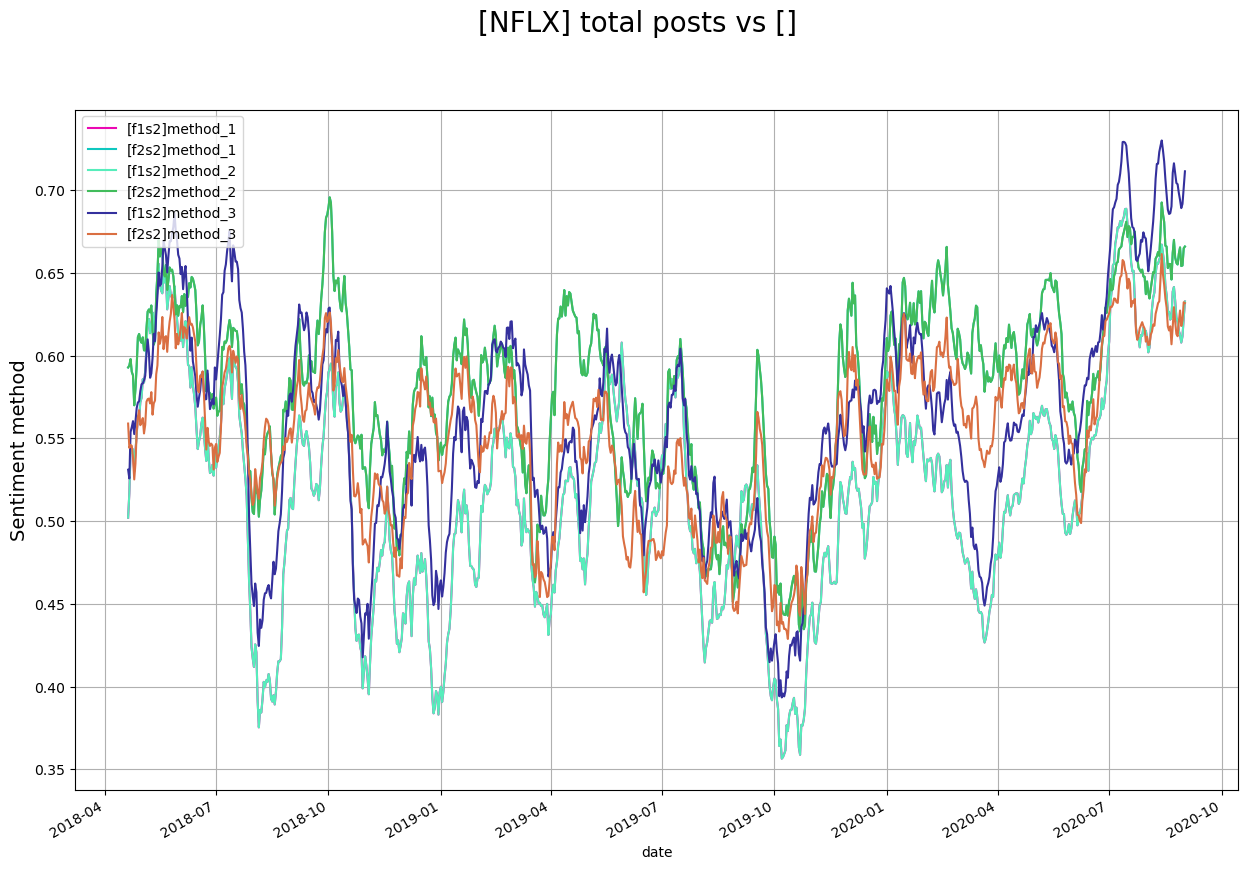

In [151]:
from sklearn.preprocessing import MinMaxScaler
import random

scaler = MinMaxScaler()

def random_colour():
    colour = "#%06x" % random.randint(0, 0xFFFFFF)
    return colour

def plot_graph(df, ticker, y1, y2=[], x='date', y1_label="", y2_label="", rolling=1):
    df.loc[:, df.columns != 'date'] = pd.DataFrame(scaler.fit_transform(df.loc[:, df.columns != 'date']), columns=df.loc[:, df.columns != 'date'].columns)

    fig, ax1 = plt.subplots(figsize=(15, 10))
    
    if len(y2) > 0:
        ax2 = ax1.twinx()
        ax2.set_ylabel(''.join(y2), fontsize=14)
        ax2.tick_params(axis="y")
        ax2.legend(loc = "upper right")
        
    for y in y1: 
        ax1.plot(df[x], df[y].rolling(rolling).mean(), label=y, color=random_colour(), lw=1.5) 
        
    for y in y2: 
        ax2.plot(df[x], df[y].rolling(rolling).mean(), label=y, color=random_colour(), lw=1.5) 
    
    
    ax1.set_xlabel(x)
    ax1.set_ylabel(y1_label, fontsize=14)
    ax1.tick_params(axis="y")
    ax1.grid()
    

    
    ax1.legend(loc = "upper left")
    fig.suptitle(f"[{ticker}] total posts vs {y2}", fontsize=20)
    fig.autofmt_xdate()
    plt.show()


plot_graph(sentiment_measures, 'NFLX', y1=['[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2',
       '[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3'], y1_label="Sentiment method", rolling=20)


## ToDo <a class="anchor" id="ToDo"></a>

In [ ]:
# results_df['test2%'].plot()
results_df['avg_sent_ratio'] = results_df['f2s2_ratio'].mean()
results_df['avg_sent_ratio2'] = results_df['f2s2_ratio'].rolling(30).mean()
results_df['avg_sent_ratio3'] = results_df['f2s2_ratio'].rolling(7).mean()
results_df['ratio2'] = (results_df['f1s1_pos'] - results_df['f1s1_neg']) / (results_df['f1s1_pos'] + results_df['f1s1_neg'])
results_df['ratio2'] = results_df['ratio2'].rolling(30).mean()
# results_df[['avg_sent_ratio','avg_sent_ratio2', 'test1']].plot()

results_df.iloc[:,:]

In [121]:
path = r"E:\Users\Christiaan\Large_Files\Thesis\taq\filtered\AMZN.csv"
df_fin = pd.read_csv(path)

sentiment_measures['date'] = pd.to_datetime(sentiment_measures['date'])
df_fin['date'] = pd.to_datetime(df_fin['date'])
df_fin = df_fin.merge(sentiment_measures, how='left', left_on='date', right_on='date')
df_fin[['price','total_vol', 'total_bs','[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2','[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3']].corr()

# df_fin.set_index('date', inplace=True)
# df_fin = df_fin.reset_index().dropna()

# # return_df[return_df['filter_1'] == True].groupby('date').mean()

# test = return_df[(return_df['filter_1'] == True) & ((return_df['s1_pos'] == 1) | (return_df['s1_neg'] == 1))][['date', 'compound_sent_1', 'compound_sent_2']].groupby('date').mean()

to_merge = return_df[(return_df['filter_2'] == True) & ((return_df['s1_pos'] == 1) | (return_df['s1_neg'] == 1))][['date', 'compound_sent_1', 'compound_sent_2']].groupby('date').mean()
test = test.merge(to_merge, left_index=True, right_index=True).reset_index().dropna()


# results_df['date'] = pd.to_datetime(results_df['date'])


# df_fin = df_fin.merge(test, how='left', left_on='date', right_on='date')
# sentiment_measures.merge(to_merge, how='left', left_on='date', right_on='date')

df_fin

Index(['Unnamed: 0', 'date', 'price', 'total_vol', 'buy', 'sell', 'buy_vol',
       'sell_vol', 'total_bs', 'total_price', 'bs_change', 'vol_change',
       '[f1s2]pos', '[f1s2]neg', '[f1s2]total', '[f2s2]pos', '[f2s2]neg',
       '[f2s2]total', '[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2',
       '[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3'],
      dtype='object')

In [122]:
df_fin[['price','total_vol', 'total_bs','[f1s2]method_1', '[f2s2]method_1', '[f1s2]method_2','[f2s2]method_2', '[f1s2]method_3', '[f2s2]method_3']].corr()


price  total_vol  total_bs  [f1s2]method_1  [f2s2]method_1  \
price           1.000000  -0.251130  0.131411        0.317048        0.258102   
total_vol      -0.251130   1.000000  0.832995       -0.220434       -0.121403   
total_bs        0.131411   0.832995  1.000000       -0.132883       -0.025221   
[f1s2]method_1  0.317048  -0.220434 -0.132883        1.000000        0.729146   
[f2s2]method_1  0.258102  -0.121403 -0.025221        0.729146        1.000000   
[f1s2]method_2  0.317048  -0.220434 -0.132883        1.000000        0.729146   
[f2s2]method_2  0.258102  -0.121403 -0.025221        0.729146        1.000000   
[f1s2]method_3  0.226128  -0.099138 -0.017878        0.660988        0.889314   
[f2s2]method_3  0.332805  -0.199154 -0.112935        0.886282        0.658118   

                [f1s2]method_2  [f2s2]method_2  [f1s2]method_3  [f2s2]method_3  
price                 0.317048        0.258102        0.226128        0.332805  
total_vol            -0.220434       -0.121403       -0.099138       -0.199154  
total_bs             -0.132883       -0.025221       -0.017878       -0.112935  
[f1s2]method_1        1.000000        0.729146        0.660988        0.886282  
[f2s2]method_1        0.729146        1.000000        0.889314        0.658118  
[f1s2]method_2        1.000000        0.729146        0.660988        0.886282  
[f2s2]method_2        0.729146        1.000000        0.889314        0.658118  
[f1s2]method_3        0.660988        0.889314        1.000000        0.724929  
[f2s2]method_3        0.886282        0.658118        0.724929        1.000000

In [56]:
df_fin[['price','f1s1_total','f2s1_total','f1s2_total', 'f2s2_total']].corr()
df_fin.columns

Index(['date', 'Unnamed: 0', 'price', 'total_vol', 'buy', 'sell', 'buy_vol',
       'sell_vol', 'total_bs', 'total_price', 'bs_change', 'vol_change',
       'compound_sent_1_x', 'compound_sent_2_x', 'compound_sent_1_y',
       'compound_sent_2_y', 'f1s1_pos', 'f1s1_neg', 'f1s1_total', 'f1s1_ratio',
       'f1s1_ratio_Δ%', 'test2%', 'f1s2_pos', 'f1s2_neg', 'f1s2_total',
       'f1s2_ratio', 'f2s1_pos', 'f2s1_neg', 'f2s1_total', 'f2s1_ratio',
       'f2s2_pos', 'f2s2_neg', 'f2s2_total', 'f2s2_ratio', 'avg_sent_ratio',
       'avg_sent_ratio2', 'avg_sent_ratio3'],
      dtype='object')

In [76]:
import random

def random_colour():
    colour = "#%06x" % random.randint(0, 0xFFFFFF)
    return colour
random_colour()

'#700aa5'

KeyError: 'compound_sent_2_y'

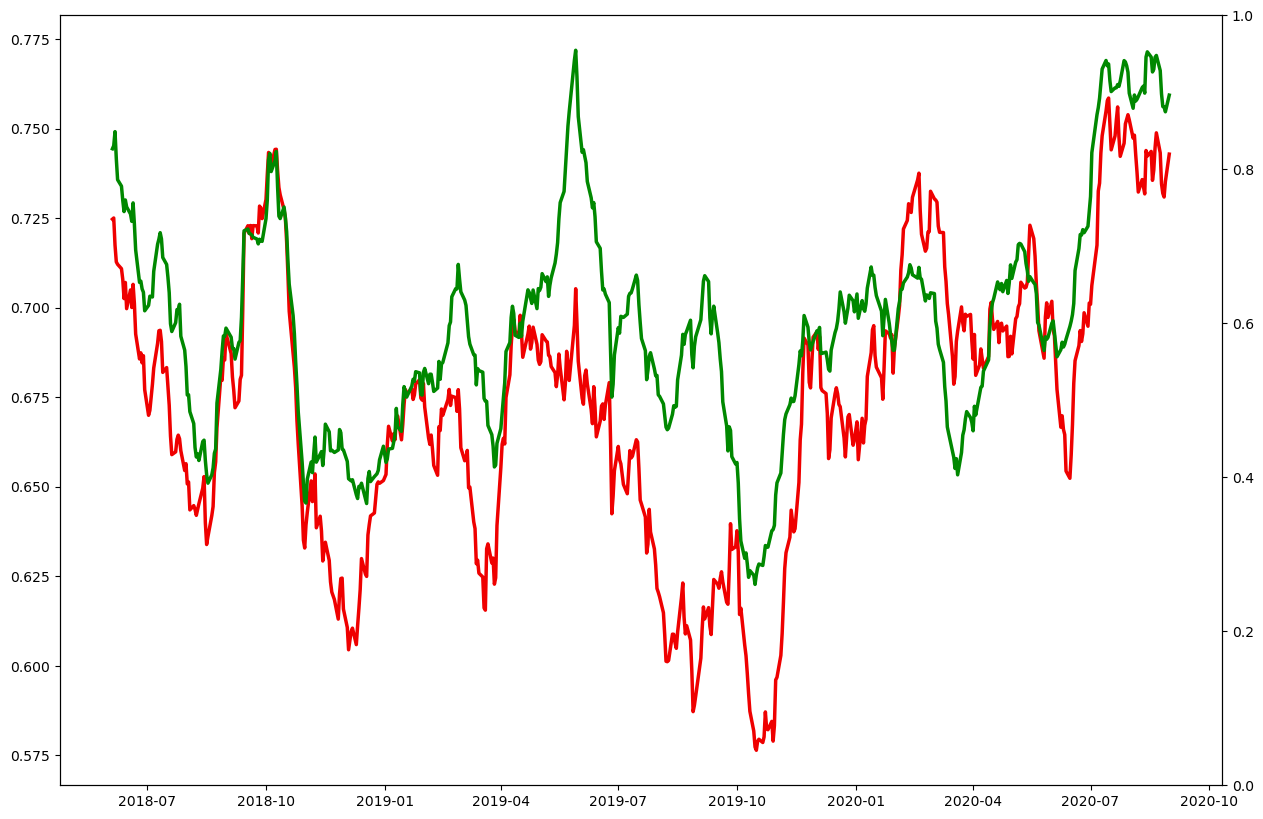

In [37]:
def plot_graph(df, ticker, x='date', y1='performance_1', y2='[taq]price'):
    
    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax2 = ax1.twinx()

    colour_1 = "#777777"
    colour_2 = "#ef0000"
    colour_3 = "#008800"
    colour_4 = "#aa22ff"
    colour_5 = "#ffff00"
    colour_6 = "#FFC300"
    
    ax1.plot(df[x], df[y1], label=y1, color=colour_1, lw=0.5) 
    ax1.plot(df[x], df[y1].rolling(20).mean(), label=f"{y1}_rolling mean", color=colour_2, lw=2.5)
    
    column = 'f1s2_ratio'
    ax1.plot(df[x], df[column].rolling(20).mean(), label=column, color=colour_3, lw=2.5) 

    column = 'compound_sent_2_y'
    ax1.plot(df[x], df[column].rolling(20).mean(), label=column, color=colour_5, lw=2.5) 
    
    column = 'ratio2'
    ax1.plot(df[x], df[column].rolling(20).mean(), label=column, color=colour_6, lw=2.5) 
    
    
#     ax2.plot(df[x], df['f2s2_pos'].rolling(20).mean(), label=y2, color=colour_3, lw=1.5)
    ax2.plot(df[x], df[y2], label=y2, color=colour_4, lw=1.5)

    # This line is a rolling average, useful for getting a better view of the data
    
    ax1.set_xlabel("Date")
    ax1.set_ylabel(y1, fontsize=14)
    ax1.tick_params(axis="y")
    ax1.grid()

    ax2.set_ylabel(y2, color=colour_4, fontsize=14)
    ax2.tick_params(axis="y")
    
    ax1.legend(loc = "upper left")
    ax2.legend(loc = "upper right")
    fig.suptitle(f"[{ticker}] {y1} vs {y2}", fontsize=20)
    fig.autofmt_xdate()
    plt.show()

plot_graph(df_fin, 'AMZN', y1='f2s2_ratio', y2='price')

In [90]:
# Check if sentiment corresponds to pos, neg or neu sentiment for compound_sent_1
return_df['s1_pos'] = np.where(return_df['compound_sent_1'] >= 0.05, 1, 0)
return_df['s1_neg'] = np.where(return_df['compound_sent_1'] <= -0.05, 1, 0)
return_df['s1_neu'] = np.where((return_df['compound_sent_1'] > -0.05) & (return_df['compound_sent_1'] < 0.05), 1, 0)

# Check if sentiment corresponds to pos, neg or neu sentiment for compound_sent_2
return_df['s2_pos'] = np.where(return_df['compound_sent_2'] >= 0.05, 1, 0)
return_df['s2_neg'] = np.where(return_df['compound_sent_2'] <= -0.05, 1, 0)
return_df['s2_neu'] = np.where((return_df['compound_sent_2'] > -0.05) & (return_df['compound_sent_1'] < 0.05), 1, 0)

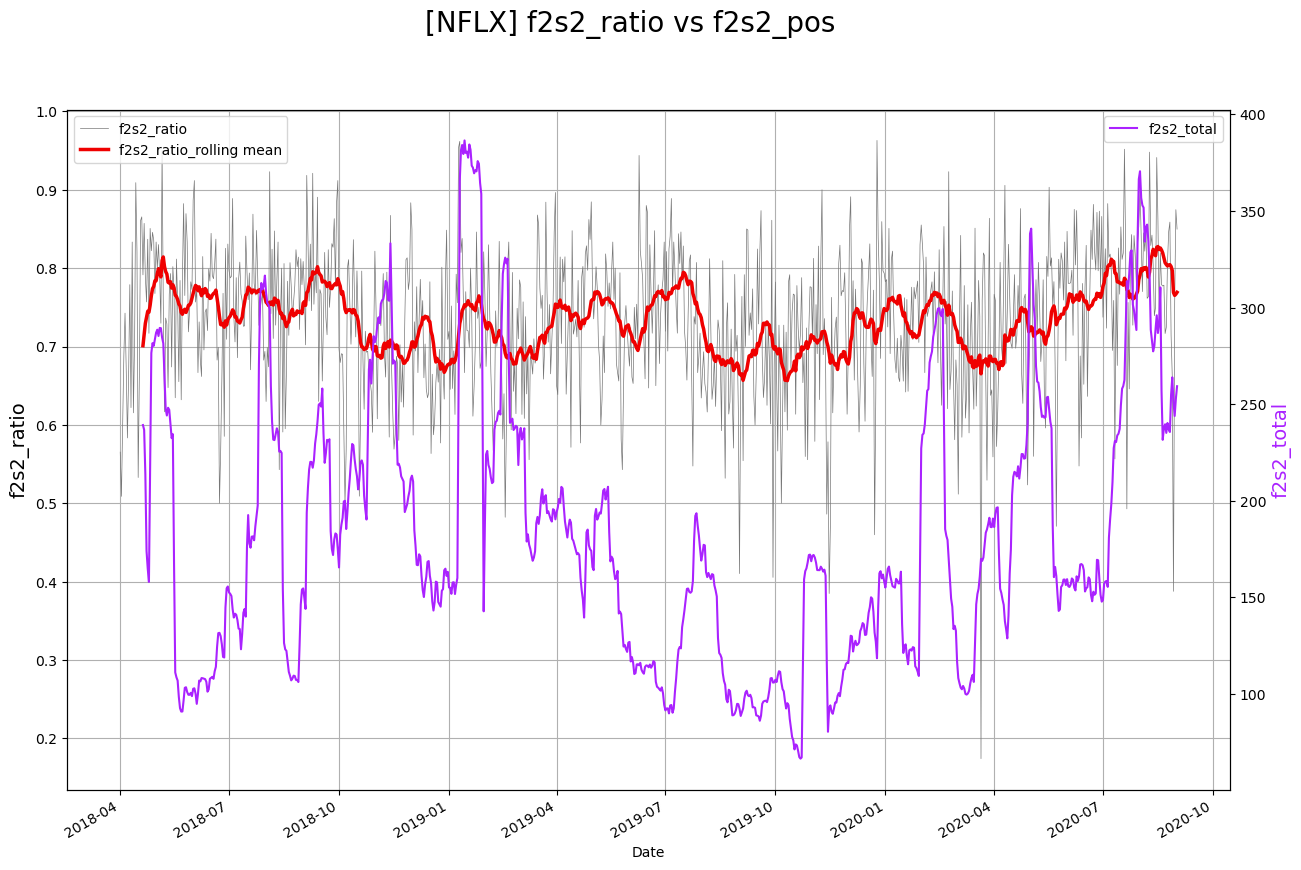

In [125]:
def plot_graph(df, ticker, x='date', y1='performance_1', y2='[taq]price'):
    
    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax2 = ax1.twinx()

    colour_1 = "#777777"
    colour_2 = "#ef0000"
    colour_3 = "#008800"
    colour_4 = "#aa22ff"
    
    ax1.plot(df[x], df[y1], label=y1, color=colour_1, lw=0.5) 
#     ax2.plot(df[x], df['f2s2_pos'].rolling(20).mean(), label=y2, color=colour_3, lw=1.5)
    ax2.plot(df[x], df['f2s2_total'].rolling(20).mean(), label='f2s2_total', color=colour_4, lw=1.5)

    # This line is a rolling average, useful for getting a better view of the data
    ax1.plot(df[x], df[y1].rolling(20).mean(), label=f"{y1}_rolling mean", color=colour_2, lw=2.5)
    
    ax1.set_xlabel("Date")
    ax1.set_ylabel(y1, fontsize=14)
    ax1.tick_params(axis="y")
    ax1.grid()

    ax2.set_ylabel("f2s2_total", color=colour_4, fontsize=14)
    ax2.tick_params(axis="y")
    
    ax1.legend(loc = "upper left")
    ax2.legend(loc = "upper right")
    fig.suptitle(f"[{ticker}] {y1} vs {y2}", fontsize=20)
    fig.autofmt_xdate()
    plt.show()

plot_graph(results_df, 'NFLX', y1='f2s2_ratio', y2='f2s2_pos')

C:\Users\Christiaan\AppData\Local\Temp\ipykernel_8664\1017810257.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  results_df[['date', 'f1s2_ratio', 'f2s2_ratio']].rolling(20).mean().plot()


<AxesSubplot:>

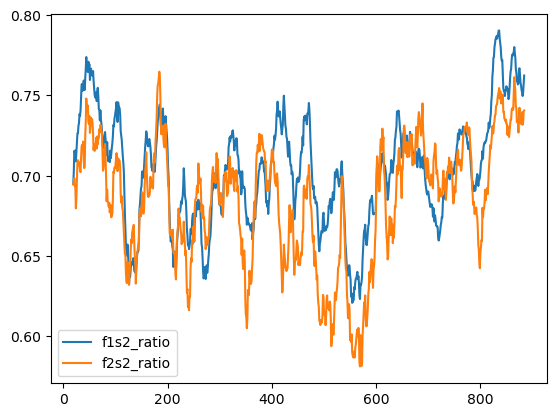

In [145]:
# results_df.loc[:, results_df.columns != 'date']
results_df[['f1s2_ratio', 'f2s2_ratio']].rolling(20).mean().plot()

In [133]:
graph_df

date    f1s1_pos    f1s1_neg  f1s1_total    f1s2_pos    f1s2_neg  \
95   2018-07-05  143.879735   46.267400  190.147135  154.625964   50.954899   
96   2018-07-06  144.983891   46.703473  191.687363  155.817758   51.464355   
97   2018-07-07  146.218102   47.220542  193.438644  157.153392   52.062669   
98   2018-07-08  147.567385   47.812597  195.379982  158.616165   52.743308   
99   2018-07-09  149.017736   48.473909  197.491645  160.190459   53.500019   
..          ...         ...         ...         ...         ...         ...   
880  2020-08-28  310.625304  107.233712  417.859016  341.338741  113.996093   
881  2020-08-29  311.500436  108.181684  419.682120  342.281022  114.928236   
882  2020-08-30  311.761078  108.888079  420.649157  342.551854  115.604435   
883  2020-08-31  311.409856  109.343336  420.753192  342.153918  116.015008   
884  2020-09-01  310.455836  109.541432  419.997268  341.097055  116.153994   

     f1s2_total    f2s1_pos   f2s1_neg  f2s1_total    f2s2_pos   f2s2_neg  \
95   205.580863   53.166748  17.948493   71.115241   58.246625  21.072669   
96   207.282113   53.840392  18.173851   72.014242   58.936711  21.336939   
97   209.216061   54.599657  18.450532   73.050189   59.724497  21.658145   
98   211.359473   55.434993  18.775819   74.210813   60.599371  22.033113   
99   213.690478   56.338172  19.147375   75.485547   61.552112  22.459088   
..          ...         ...        ...         ...         ...        ...   
880  455.334834  107.017020  46.253070  153.270090  121.130311  50.368788   
881  457.209258  108.221601  46.889550  155.111151  122.393830  51.040073   
882  458.156289  109.099654  47.367968  156.467622  123.286677  51.545218   
883  458.168926  109.640808  47.682134  157.322942  123.798184  51.877304   
884  457.251049  109.839085  47.828049  157.667134  123.922662  52.031735   

     f2s2_total  
95    79.319294  
96    80.273651  
97    81.382642  
98    82.632484  
99    84.011201  
..          ...  
880  171.499099  
881  173.433902  
882  174.831895  
883  175.675488  
884  175.954397  

[790 rows x 13 columns]

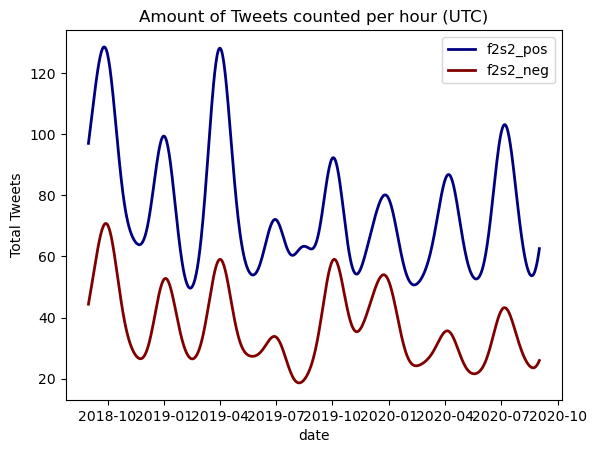

In [136]:
graph_df = results_df
graph_df.loc[:, graph_df.columns != 'date'] = results_df.loc[:, results_df.columns != 'date'].rolling(20).mean()
graph_df.dropna(inplace=True)
# Plot results
ax = graph_df.plot(x="date", y=["f2s2_pos", "f2s2_neg"], lw=2, colormap='jet', markersize=10, title='Amount of Tweets counted per hour (UTC)')
ax.set(xlabel="date", ylabel="Total Tweets")
plt.show()

In [18]:
# pd.set_option('display.max_colwidth', None)

for index, row in return_df[['text2', 'compound_sent', 'compound_sent2']].iloc[1000:1400].iterrows():
#     if row['compound_sent'] != row['compound_sent2']:
    print(row['text2'])
    print(f"Sentiment {row['compound_sent']} --> {row['compound_sent2']}")
    print()


 Netflix offering more than $300 million for billboard company: sources    $NFLX
Sentiment 0.0 --> 0.0

 Netflix offering more than $300 million for billboard company: sources    $NFLX
Sentiment 0.0 --> 0.0

Netflix seeks eyeballs on both high &amp; low tech screens. $NFLX 
Sentiment -0.2732 --> -0.2732

 Netflix $NFLX offering $300M for billboard co. Regency Outdoor Advertising - Reuters 


Sentiment 0.0 --> 0.0

Netflix $NFLX offering $300M for billboard co. Regency Outdoor Advertising - Reuters 


Sentiment 0.0 --> 0.0

Netflix offering more than $300 million for billboard company: sources    $NFLX
Sentiment 0.0 --> 0.0

Netflix, Inc. $NFLX Quarterly Estimates Raised at Needham Citing Higher Int'l Subscribers 
Sentiment 0.0 --> 0.0

Raymond James &amp; Associates Buys 490 Shares of Netflix $NFLX  
Sentiment 0.296 --> 0.296

With price to earnings north of 275 and price to sales at 12, Netflix is madly overvalued. The growth potential is not real.  #stocks $NFLX 
Sentiment -0.0258 --

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
SIA = SentimentIntensityAnalyzer()

text = "I am very bearish target $290.55"
# text = "$NFLX wants $300 . Give it some momentum or news and we 🚀🚀"
# text = "Netflix $NFLX Upgraded to Buy by Zacks Investment Research"
# text = "$tsla 🚀🚀🚀"
text = "📈📉"
text = "$NFLX is my hottest playfor April 📈"
text = "Netflix will exist for a long time as a company. It's valuation however is madness. It's too expensive and it's not a viable investment in the long term. $NFLX  #NetflixEurope #StockMarket #stocks #investing"
result = SIA.polarity_scores(text)
print(result)

new_words = {}

# Adding custom postive words
positive_words = {
    'buy': 2.0,
    'buying': 2.0,
    'bullish': 2.0,
    'long': 1.0,
    'call': 1.0,
    'calls': 1.0,
    'rocket': 3.0,        # Added for 'rocket' emoji 🚀
    'increasing': 2.0,     # Added for 'chart increasing' emoji 📈
    'to the moon': 2.5,
    "undervalued": 2.0
}
# Adding custom negative words
negative_words = {
    'decreasing': -2.0,   # Added for 'chart increasing' emoji 📉
    'sell': -2.0,
    'selling': -2.0,
    'bearish': -2.0,
    'put': -1,
    'puts': -1,
    'short': -1.0,
    'shorting': -1.5,
    "overvalued": -2.0,
    'expensive': -1.5
}


# Adding positive and negative words to new_worddictionary
new_words.update(positive_words)
new_words.update(negative_words)

SIA = SentimentIntensityAnalyzer()
SIA.lexicon.update(new_words)


result = SIA.polarity_scores(text)
print(result)

{'neg': 0.083, 'neu': 0.917, 'pos': 0.0, 'compound': -0.4404}
{'neg': 0.141, 'neu': 0.755, 'pos': 0.104, 'compound': -0.34}


In [76]:
print(str("🚀"))

🚀


<AxesSubplot:>

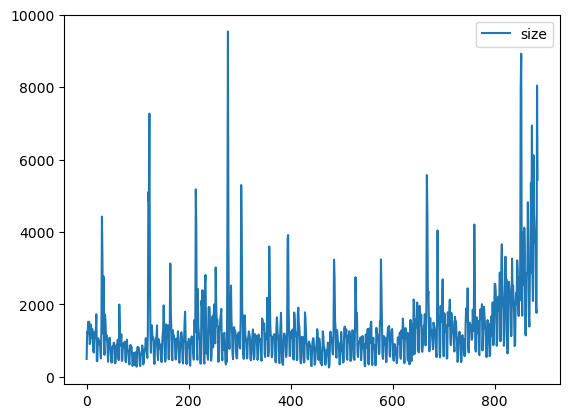

In [31]:
df.groupby('date', as_index=False).size().plot()

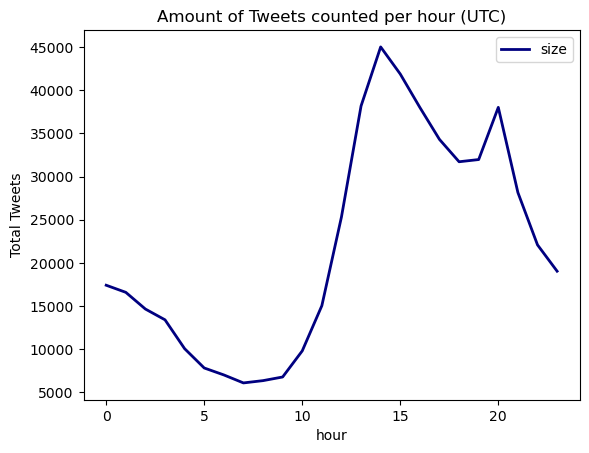

In [28]:
path = r"E:\Users\Christiaan\Large_Files\Thesis\Twitter\merged\NFLX.csv"
df = pd.read_csv(path)

day_activity = df.groupby('hour', as_index=False).size()

# Plot results
ax = day_activity.plot(x="hour", y=["size"], lw=2, colormap='jet', markersize=10, title='Amount of Tweets counted per hour (UTC)')
ax.set(xlabel="hour", ylabel="Total Tweets")
plt.show()

## Graphs

Checking when Twitter activity is highest, it seems that Twitter activity is highest at the 14:00 mark, and lowest at 07:00.

Apple (AAPL) shows the following results
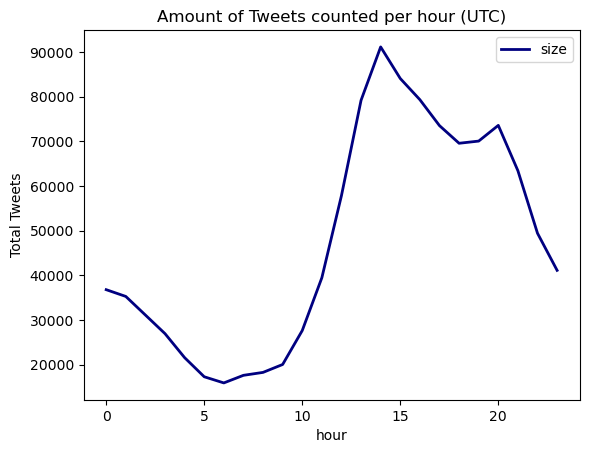

Netflix (NFLX) shows similar results
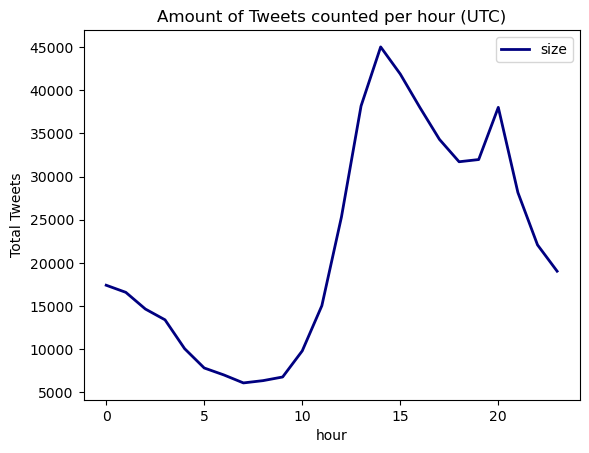

# Vault <a class="anchor" id="vault"></a>

 [Go back up](#top)

In [18]:
import mitosheet
# mitosheet.sheet(analysis_to_replay="id-imkivuhrdi")
mitosheet.sheet(results_df)

In [13]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

In [16]:
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, device=0)
sentence_list = ['With a massive increase in profitability, the stock gains of Tesla were not unexpected']
results = nlp(sentence_list)
print(results)  #LABEL_0: neutral; LABEL_1: positive; LABEL_2: negative

[{'label': 'Positive', 'score': 0.9979656934738159}]


In [27]:
import torch
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce GTX 750 Ti


In [15]:
import time

def calculate_runtime(function):
    """
    A wrapper function that calculates the runtime of the specified function.
    """
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = function(*args, **kwargs)
        end_time = time.time()
        print(f"Runtime for {function.__name__}: {end_time - start_time} seconds")
        return result
    return wrapper

In [30]:
@calculate_runtime
def calc_rows(size):
    for row in range(size):
        calc_sent_finbert(size)
def calc_sent_finbert(row):
    nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, device=0)

    sentence_list = return_df.iloc[row:row+1]['text'].tolist()
    results = nlp(sentence_list)
    # print(results)  #LABEL_0: neutral; LABEL_1: positive; LABEL_2: negative

size_list = [10, 100, 1000, 10000]

for size in size_list:
    print(f"Calcing sent for [{size}] sentences")
    calc_rows(size)





Calcing sent for [10] sentences
Runtime for calc_rows: 0.3248138427734375 seconds
Calcing sent for [100] sentences
Runtime for calc_rows: 1.7200281620025635 seconds
Calcing sent for [1000] sentences
Runtime for calc_rows: 14.51870059967041 seconds
Calcing sent for [10000] sentences
Runtime for calc_rows: 366.51324224472046 seconds


In [37]:
@calculate_runtime
def calc_sent_finbert(size):
    nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, device=0)

    sentence_list = return_df.iloc[:size]['text'].tolist()
    results = nlp(sentence_list)
    # print(results)  #LABEL_0: neutral; LABEL_1: positive; LABEL_2: negative

size_list = [10, 100, 1000, 10000, 20000]

for size in size_list:
    print(f"Calcing sent for [{size}] sentences")
    calc_sent_finbert(size)





Calcing sent for [10] sentences
Runtime for calc_sent_finbert: 0.14393019676208496 seconds
Calcing sent for [100] sentences
Runtime for calc_sent_finbert: 1.7862770557403564 seconds
Calcing sent for [1000] sentences
Runtime for calc_sent_finbert: 17.48098874092102 seconds
Calcing sent for [10000] sentences
Runtime for calc_sent_finbert: 172.90117263793945 seconds
Calcing sent for [20000] sentences
Runtime for calc_sent_finbert: 359.7904999256134 seconds


In [ ]:
# df.groupby('date').agg(
#         {'price': 'mean', 'size': 'sum', 'buy': 'sum', 'sell': 'sum', 'buy_vol': 'sum', 'sell_vol': 'sum'})
#           .round(2)
#           .rename(columns={'size': 'total_vol'})